<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/6zEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPool2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential




## Tensorflow Datasets

In this section we will familiarize ourselves with the Dataset object in Tensorflow

In [45]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [46]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [47]:
train_dataset=train_dataset.batch(16,drop_remainder=True)
print(train_dataset.cardinality())

print(train_dataset.element_spec)
e=train_dataset.take(1)
for img,label in e:
  print(label.numpy())

tf.Tensor(3750, shape=(), dtype=int64)
(TensorSpec(shape=(16, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(16,), dtype=tf.uint8, name=None))
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


## Upload Kaggle Token

You will be prompted to upload your kaggle.json file to be able to access the kaggle API.

In [48]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip>/dev/null



Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Retrieving the data as a Dataset Object

We use the image_dataset_from_directory to build a dataset from all the downloaded images. It is important to set the shuffle option to False for the test_dataset

In [49]:
image_size=(48,48)
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size,
                                                            shuffle=True,color_mode="grayscale")
test_dataset=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=64,image_size=image_size,
                                                            shuffle=False,color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


print the class names

In [50]:
dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

We can iterate over the dataset. Note each "element"  is a batch of batch_size

In [51]:
iterator=iter(dataset)
(imgs,labels)=iterator.next()
print(imgs.shape,labels.shape)


(64, 48, 48, 1) (64,)


Display an image from the dataset

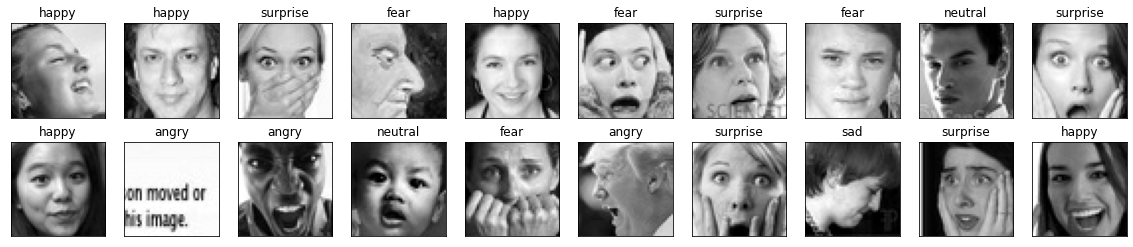

In [52]:
fig=plt.figure(figsize=(20,4))
#fig.tight_layout()
#plt.subplots_adjust( wspace=4)
for i in range(20):

            t=fig.add_subplot(2,10,i+1)
            # set the title of the image equal to its label
            t.set_title(str(dataset.class_names[labels[i].numpy()]))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(np.squeeze(imgs[i]),cmap='gray')

## Building the model

In [53]:
def get_model(nb_classes=7):
    model = Sequential()
    model.add(Input(shape=(image_size[0],image_size[1],1)))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
        
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation = 'softmax', name = 'Output'))
    model.summary()
    return model

### Add optimizer, loss and metrics

In [54]:
model=get_model(nb_classes=7)
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 256)       2

In [55]:
try:
  model.load_weights("emotions_weights.h5")
except:
  pass

## Run optimizer

In [56]:
model.fit(dataset,validation_data=test_dataset,epochs=20)

Epoch 1/20
449/449 [==============================] - 21s 46ms/step - loss: 1.7308 - accuracy: 0.2980 - val_loss: 1.5706 - val_accuracy: 0.3884
Epoch 2/20
449/449 [==============================] - 20s 46ms/step - loss: 1.5001 - accuracy: 0.4202 - val_loss: 1.3789 - val_accuracy: 0.4698
Epoch 3/20
449/449 [==============================] - 20s 46ms/step - loss: 1.3618 - accuracy: 0.4748 - val_loss: 1.2571 - val_accuracy: 0.5170
Epoch 4/20
449/449 [==============================] - 21s 46ms/step - loss: 1.2918 - accuracy: 0.4993 - val_loss: 1.2032 - val_accuracy: 0.5371
Epoch 5/20
449/449 [==============================] - 20s 45ms/step - loss: 1.2349 - accuracy: 0.5265 - val_loss: 1.1817 - val_accuracy: 0.5450
Epoch 6/20
449/449 [==============================] - 21s 46ms/step - loss: 1.1957 - accuracy: 0.5445 - val_loss: 1.1498 - val_accuracy: 0.5649
Epoch 7/20
449/449 [==============================] - 20s 45ms/step - loss: 1.1562 - accuracy: 0.5635 - val_loss: 1.1390 - val_accuracy:

Save the weights for later retrival and evaluate the model on the test data

In [57]:
model.save_weights("emotions_weights.h5")
model.evaluate(test_dataset)

113/113 [==============================] - 3s 27ms/step - loss: 1.0852 - accuracy: 0.6010


[1.0852161645889282, 0.6010030508041382]

# Prediction Accuracy and Confusion Matrix

In [58]:
probabilities=model.predict(test_dataset)
predictions=np.argmax(probabilities,axis=1)
print(predictions[0:10])
predictions.shape

[3 0 5 0 0 2 0 0 3 0]


(7178,)

### Combine the "true" labels into an array

In [59]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y.shape

(7178,)

### Count the number of correct and wrong predictions

In [60]:

compare=y==predictions
unique,count=np.unique(compare,return_counts=True)
print(unique)
print(count)

[False  True]
[2864 4314]


### Confusion Matrix
The percentage of correct/wrong predictions doesn't tell the whole story. Some emotions are more correctly predicted than others. Towards that end we compute the confusion matrix

In [61]:
m=tf.math.confusion_matrix(y,predictions)
m

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 456,    5,   89,   78,  126,  171,   33],
       [  28,   46,    7,    5,    5,   17,    3],
       [ 120,    1,  348,   59,  151,  240,  105],
       [  43,    0,   26, 1493,   83,   83,   46],
       [  73,    1,   62,  147,  707,  227,   16],
       [ 110,    1,  134,  104,  239,  632,   27],
       [  19,    1,   70,   50,   32,   27,  632]], dtype=int32)>

In [62]:
totals=np.sum(m.numpy(),axis=1)

for i in range(7):
  print("{}={:.3f}".format(dataset.class_names[i],m[i,i].numpy()/totals[i]))

angry=0.476
disgust=0.414
fear=0.340
happy=0.842
neutral=0.573
sad=0.507
surprise=0.761


### Plotting the Confusion Matrix

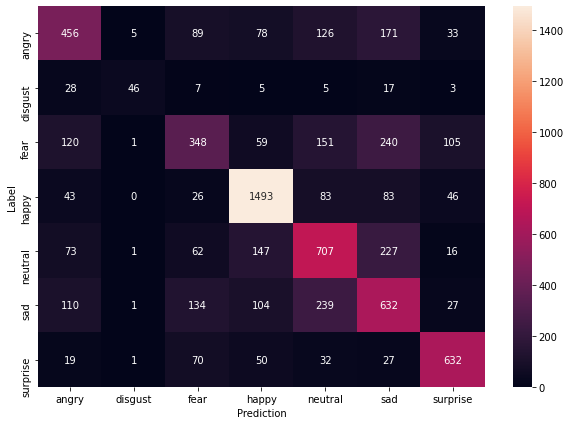

In [63]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(m, xticklabels=dataset.class_names, yticklabels=dataset.class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Classifying your own photo

In this part you will take a photo of yourself and classify it using a similar model. We will keep only 3 states : angry, happy and neutral. The easiest way is to delete the images for all the other categories and reload the dataset

In [64]:
!rm -rf train/disgust train/fear train/sad train/surprise

In [106]:
image_size=(48,48)
train_dir="c:/Users/hikmat/Downloads/fer2013/train"
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size, shuffle=True,color_mode="grayscale")
model=get_model(nb_classes=3)
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])


Found 16175 files belonging to 3 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_15 (C

KeyboardInterrupt: ignored

In [107]:
model.fit(dataset,epochs=20)

Epoch 1/20
253/253 [==============================] - 12s 47ms/step - loss: 1.0692 - accuracy: 0.4510
Epoch 2/20
253/253 [==============================] - 11s 45ms/step - loss: 0.9214 - accuracy: 0.5717
Epoch 3/20
253/253 [==============================] - 11s 44ms/step - loss: 0.8182 - accuracy: 0.6301
Epoch 4/20
253/253 [==============================] - 11s 44ms/step - loss: 0.7471 - accuracy: 0.6670
Epoch 5/20
253/253 [==============================] - 11s 44ms/step - loss: 0.6965 - accuracy: 0.6977
Epoch 6/20
253/253 [==============================] - 11s 44ms/step - loss: 0.6693 - accuracy: 0.7072
Epoch 7/20
253/253 [==============================] - 11s 44ms/step - loss: 0.6408 - accuracy: 0.7262
Epoch 8/20
253/253 [==============================] - 11s 44ms/step - loss: 0.6211 - accuracy: 0.7356
Epoch 9/20
253/253 [==============================] - 11s 44ms/step - loss: 0.6012 - accuracy: 0.7440
Epoch 10/20
253/253 [==============================] - 11s 44ms/step - loss: 0.579

In [67]:
# I have no idea who is the author of the code
# in this cell that saves an image from a webcam
# inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [108]:
img=take_photo(size=(256,256))

In [69]:
import cv2
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-11-14 17:05:43--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2020-11-14 17:05:43 (31.3 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [109]:
classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
## convert to gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
##get the bounding box of the face
bboxes = classifier.detectMultiScale(img)
bboxes=np.squeeze(bboxes)
x,y,width,height=bboxes
## extract the face
face=img[x:x+width,y:y+height]
face = cv2.resize(face, (48,48), interpolation = cv2.INTER_CUBIC)


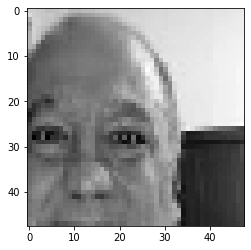

In [110]:
plt.imshow(face,cmap="gray")

In [111]:
r=np.expand_dims(face,0)
r=np.expand_dims(r,3)
r.shape

(1, 48, 48, 1)

In [112]:
res=model.predict(r)

In [113]:
print(res)
dataset.class_names

[[0.03753056 0.15840615 0.80406326]]


['angry', 'happy', 'neutral']